In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from keras import backend as K

%config InlineBackend.figure_format = 'retina'
import pandas as pd
%matplotlib inline
from keras import activations, initializers
from keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow_probability.python.layers import DistributionLambda
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('scaled_dummied_task.csv')
df.head()

,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,...,Input2_PP,Input2_PS,Input2_PUR,Input2_PVC,Input3_LiBF4,Input3_LiCF3SO3,Input3_LiClO4,Input3_LiClO6,Input3_LiI,Input3_LiTFSI
0,0.622395,0.011976,0.606610,0.731429,0.066680,0.451278,0.233309,0.180905,0.044839,0.398350,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.218718,0.674737,0.440686,0.420000,0.141265,0.111310,0.649603,0.809045,0.390311,0.354744,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.647225,0.086764,0.587247,0.345714,0.199027,0.909455,0.761932,0.909548,0.960022,0.429582,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.901855,0.769879,0.973403,0.280000,0.976388,0.074506,0.314636,0.301508,0.060889,0.883324,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.987885,0.076741,0.412419,0.442857,0.609039,0.827567,0.992646,0.698492,0.336337,0.506187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
x_train = df.drop('Target', axis = 1)
y_train = df['Target']

In [4]:
noise = 1
def neg_log_likelihood_with_dist(y_true, y_pred, sigma = noise):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [5]:
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma
  
def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))
  
# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

In [6]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential(
        [tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
])

In [7]:
n_epochs = 100000
lr = 5e-3
batch_size = x_train.shape[0]

In [8]:
def build_model(train_size):
    model_in = Input(shape=(x_train.shape[1],))
    x = tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    model_out_loc = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                                                                      model_out_scale])
    model = Model(model_in, model_out)
    return model

model = build_model(len(x_train))
model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
dense_variational (DenseVariati (None, 32)           3360        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32)           0           dense_variational[0][0]          
__________________________________________________________________________________________________
dense_variational_1 (DenseVaria (None, 32)           3168        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [9]:
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1)

Train on 600 samples
600/600 [==============================] - 1s 2ms/sample - loss: 1139.5110 - mse: 1195.2898


In [10]:
permuts = pd.read_csv('../HolyGrail/permutations.csv')

In [11]:
y_pred_list = []
for i in range(len(permuts)):
    tensor = tf.constant([permuts.iloc[i]], dtype='float32')
    pred_list = []
    for j in range(500):
        y_pred = model.predict(tensor)
        pred_list.append(y_pred)
    y_pred_list.append(pred_list)

In [12]:
y_means = np.mean(y_pred_list, axis = 1)
y_sigmas = np.std(y_pred_list, axis = 1)

In [13]:
y_sigmas = y_sigmas.reshape(len(permuts),)
y_means = y_means.reshape(len(permuts),)

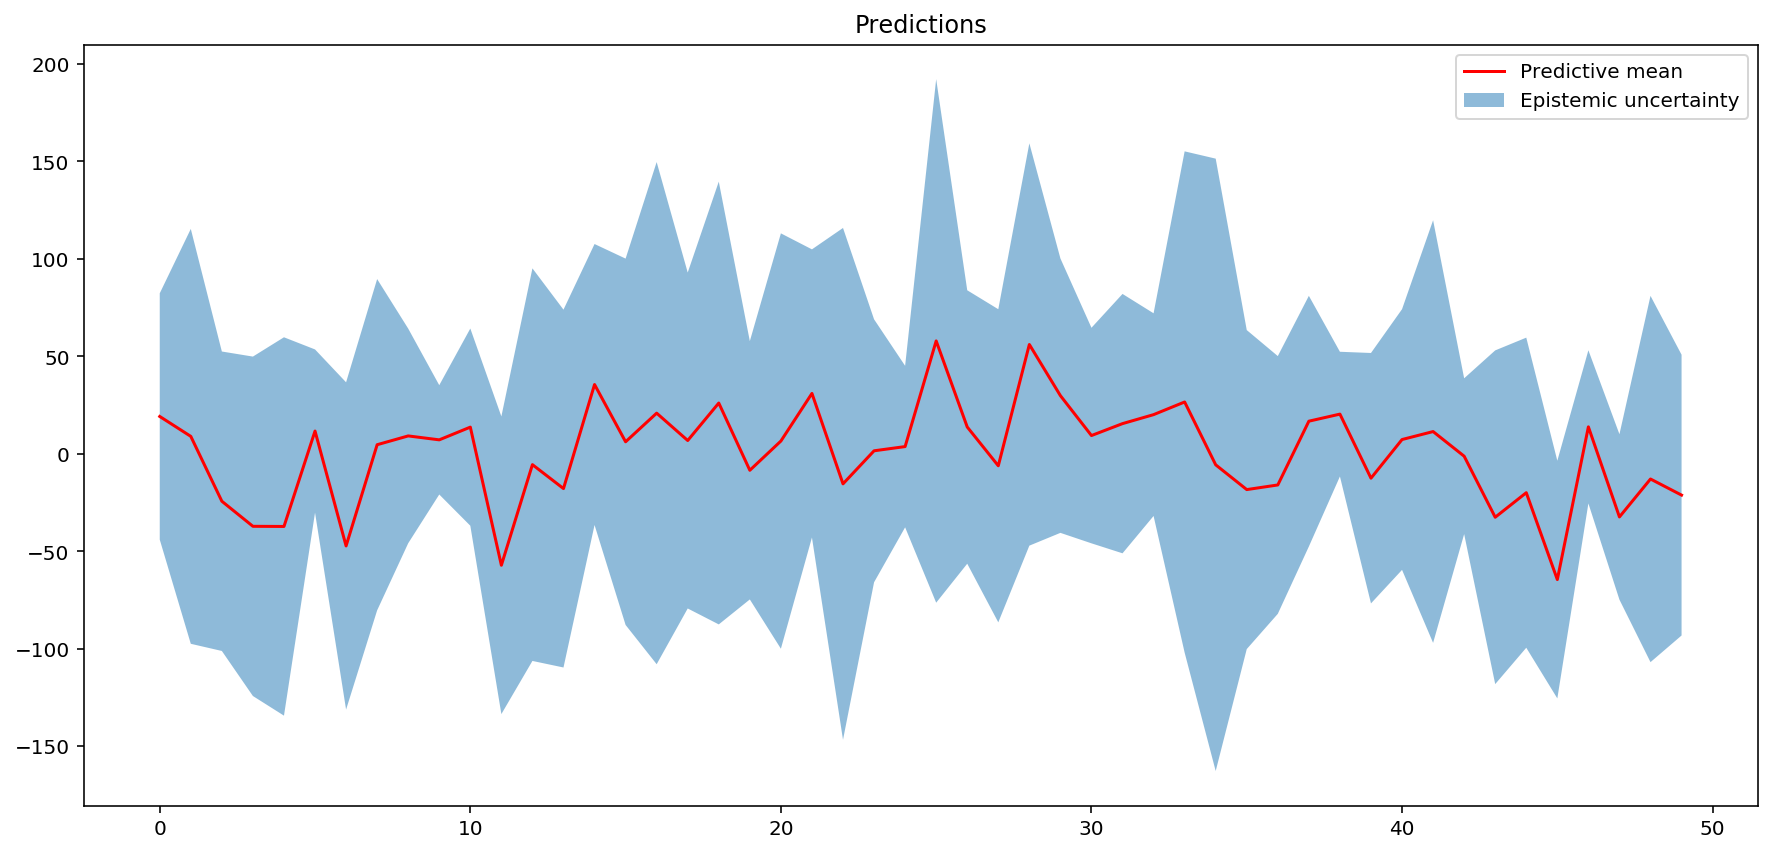

In [14]:
idx = range(len(permuts))
plt.figure(figsize = (15, 7))
plt.plot(idx, y_means, 'r-', label='Predictive mean');
plt.fill_between(idx, y_means + 2 * y_sigmas,
                 y_means - 2 * y_sigmas, alpha=0.5, label='Epistemic uncertainty')
plt.legend()
plt.title('Predictions');